In [1]:
!gdown 1Rqo37xGjPBE3JfMMKBDkDBFNxa1A2Yl1

Downloading...
From: https://drive.google.com/uc?id=1Rqo37xGjPBE3JfMMKBDkDBFNxa1A2Yl1
To: /content/windspeed.csv
100% 92.4k/92.4k [00:00<00:00, 90.0MB/s]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
wind = pd.read_csv('windspeed.csv')

In [4]:
wind

,Windspeed (km/s)
0,385.70444
1,378.57290
2,370.32120
3,369.08807
4,360.67133
...,...
8731,6085.82280
8732,382.35640
8733,377.20566
8734,367.56927


In [5]:
windspeed = wind['Windspeed (km/s)']

In [6]:
ws = np.array(windspeed)

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [8]:
ws

array([ 385.70444,  378.5729 ,  370.3212 , ...,  377.20566,  367.56927,
       3203.2878 ])

In [9]:
for i in range(len(ws)):
  if ws[i] > 9999.9:
    ws[i] = 9999.9

In [10]:
time_step = [i for i in range(len(ws))]

In [11]:
len(ws)

8736

In [12]:
split_time = 8000

# Get the train set 
time_train = time_step[:split_time]
x_train = ws[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = ws[split_time:]

In [13]:
w = ws.reshape(-1,1)

In [14]:
w.shape

(8736, 1)

In [15]:
scaler = MinMaxScaler()
scaler = scaler.fit(w)
x_train = scaler.transform(x_train.reshape(-1,1))

In [16]:
x_train = x_train[:,0]

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [18]:
window_size = 24
batch_size = 100
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [20]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
Wsave = model.get_weights()
 # Print the model summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 24, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           98816     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 80)                10320     
                                                                 
 dense_4 (Dense)             (None, 10)                810       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 241,797
Trainable params: 241,797
Non-tr

In [21]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
80/80 [==============================] - 18s 20ms/step - loss: 0.1356 - lr: 1.0000e-08
Epoch 2/100
80/80 [==============================] - 1s 15ms/step - loss: 0.1356 - lr: 1.1220e-08
Epoch 3/100
80/80 [==============================] - 1s 14ms/step - loss: 0.1356 - lr: 1.2589e-08
Epoch 4/100
80/80 [==============================] - 1s 14ms/step - loss: 0.1356 - lr: 1.4125e-08
Epoch 5/100
80/80 [==============================] - 1s 15ms/step - loss: 0.1356 - lr: 1.5849e-08
Epoch 6/100
80/80 [==============================] - 1s 15ms/step - loss: 0.1356 - lr: 1.7783e-08
Epoch 7/100
80/80 [==============================] - 1s 15ms/step - loss: 0.1356 - lr: 1.9953e-08
Epoch 8/100
80/80 [==============================] - 2s 21ms/step - loss: 0.1356 - lr: 2.2387e-08
Epoch 9/100
80/80 [==============================] - 1s 15ms/step - loss: 0.1356 - lr: 2.5119e-08
Epoch 10/100
80/80 [==============================] - 1s 15ms/step - loss: 0.1356 - lr: 2.8184e-08
Epoch 11/100
80/80

(1e-08, 0.001, 0.0, 1.0)

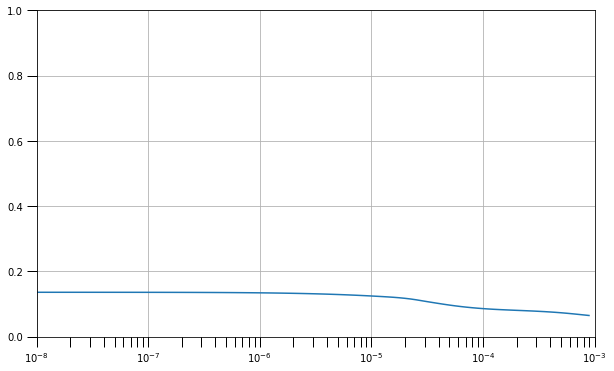

In [22]:
import matplotlib.pyplot as plt

lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1])

In [23]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [27]:
tf.keras.backend.clear_session()
model.set_weights(Wsave)

learning_rate = 8.9125e-04

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [28]:
history = model.fit(train_set,epochs=500)

Epoch 1/500
80/80 [==============================] - 5s 15ms/step - loss: 0.1043 - mae: 0.3087
Epoch 2/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0822 - mae: 0.3474
Epoch 3/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0793 - mae: 0.3476
Epoch 4/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0769 - mae: 0.3437
Epoch 5/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0745 - mae: 0.3384
Epoch 6/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0719 - mae: 0.3315
Epoch 7/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0694 - mae: 0.3252
Epoch 8/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0672 - mae: 0.3178
Epoch 9/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0652 - mae: 0.3101
Epoch 10/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0635 - mae: 0.3016
Epoch 11/500
80/80 [=============================

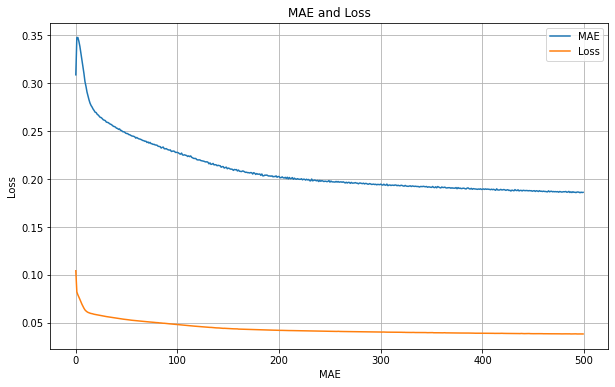

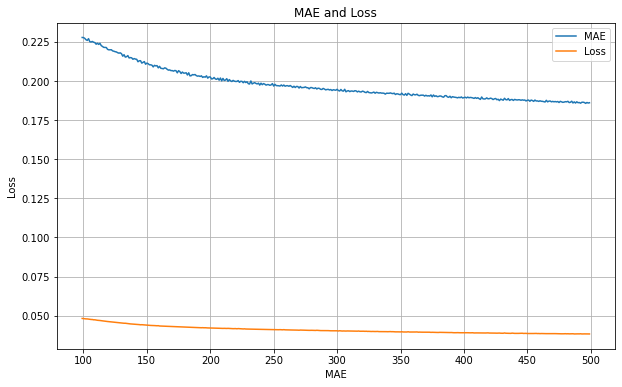

In [29]:
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [30]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    series = scaler.transform(series.reshape(-1,1))
    series = series[:,0]
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    forecast = scaler.inverse_transform(forecast.reshape(-1,1))
    forecast = forecast[:,0]
    
    return forecast

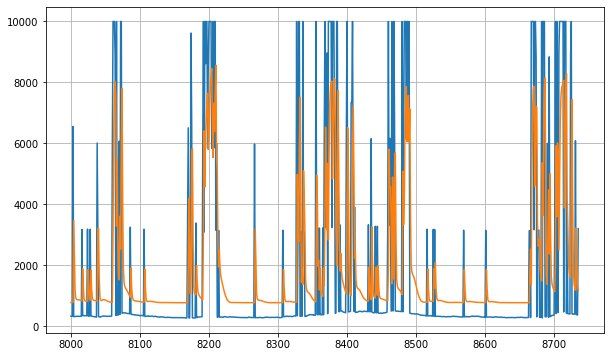

In [31]:
forecast_series = ws[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [32]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1531.9572


In [33]:
model.save('128,128,80,10.h5')